In [1]:
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
trainset = h5py.File("09072022_1154_train.h5", "r")
validateset = h5py.File("09072022_1154_val.h5", "r")
testset = h5py.File("09072022_1154_test.h5", "r")

In [3]:
trainset.keys()

<KeysViewHDF5 ['agbd', 'cloud', 'images', 'lat', 'lon', 'scl']>

## Explore datasets

In [3]:
# train
train_images = np.array(trainset['images'],dtype=np.float32)
train_images = train_images.transpose(0,3,1,2)

train_biomasses = np.array(trainset['agbd'],dtype=np.float16)

# validate
validate_images = np.array(validateset['images'],dtype=np.float32)
validate_images = validate_images.transpose(0,3,1,2)
validate_biomasses = np.array(validateset['agbd'],dtype=np.float32)

# test 
test_images = np.array(testset['images'],dtype=np.float32)
test_images = test_images.transpose(0,3,1,2)
test_biomasses = np.array(testset['agbd'],dtype=np.float16)

#
s2_images_h5 = h5py.File("images_test.h5", "r")
s2_images = np.array(s2_images_h5["images"], dtype=np.float32)
test = s2_images.transpose(0,3,1,2)

train_cloud=np.array(trainset['cloud'],dtype=np.float64)
#train_cloud=pd.DataFrame(train_cloud.reshape(train_cloud.shape[0], 225))
train_lat=np.array(trainset['lat'],dtype=np.float64)
#train_lat=pd.DataFrame(train_lat.reshape(train_lat.shape[0], 225))

train_lon=np.array(trainset['lon'],dtype=np.float64)
#train_lon=pd.DataFrame(train_lon.reshape(train_lon.shape[0], 225))
train_scl=np.array(trainset['scl'],dtype=np.float64)
#train_scl=pd.DataFrame(train_scl.reshape(train_scl.shape[0], 225))

val_cloud=np.array(validateset['cloud'],dtype=np.float64)
#val_cloud=pd.DataFrame(val_cloud.reshape(val_cloud.shape[0], 225))
val_lat=np.array(validateset['lat'],dtype=np.float64)
#val_lat=pd.DataFrame(val_lat.reshape(val_lat.shape[0], 225))
val_lon=np.array(validateset['lon'],dtype=np.float64)
#val_lon=pd.DataFrame(val_lon.reshape(val_lon.shape[0], 225))
val_scl=np.array(validateset['scl'],dtype=np.float64)
#val_scl=pd.DataFrame(val_scl.reshape(val_scl.shape[0], 225))

test_cloud=np.array(testset['cloud'],dtype=np.float64)
#test_cloud=pd.DataFrame(test_cloud.reshape(test_cloud.shape[0], 225))
test_lat=np.array(testset['lat'],dtype=np.float64)
#test_lat=pd.DataFrame(test_lat.reshape(test_lat.shape[0], 225))
test_lon=np.array(testset['lon'],dtype=np.float64)
#test_lon=pd.DataFrame(test_lon.reshape(test_lon.shape[0], 225))
test_scl=np.array(testset['scl'],dtype=np.float64)
#test_scl=pd.DataFrame(test_scl.reshape(test_scl.shape[0], 225))

scloud=np.array(h5py.File("TestFiles/cloud_test.h5", "r")['cloud'], dtype=np.float64)
slat=np.array(h5py.File("TestFiles/lat_test.h5", "r")['lat'], dtype=np.float64)
slon=np.array(h5py.File("TestFiles/lon_test.h5", "r")['lon'], dtype=np.float64)
sscl=np.array(h5py.File("TestFiles/scl_test.h5", "r")['scl'], dtype=np.float64)

#### Data visualization

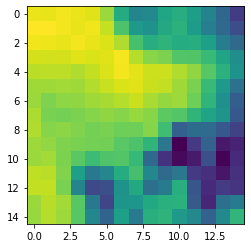

In [43]:
nivd=(train_images[:, 7, :, :]-train_images[:, 3, :, :])/(train_images[:, 7, :, :]+train_images[:, 3, :, :])
plt.imshow(nivd[123, :, :])
plt.show()

#### Faeature enginerring on band indice

In [4]:
train=(train_images[:, 7, :, :]-train_images[:, 3, :, :])/(train_images[:, 7, :, :]+train_images[:, 3, :, :])
train_nvdi=train.reshape(25036, 15*15)
val=(validate_images[:, 7, :, :]-validate_images[:, 3, :, :])/(validate_images[:, 7, :, :]+validate_images[:, 3, :, :])
val_nvdi=val.reshape(val.shape[0], 15*15)
val2=(test_images[:, 7, :, :]-test_images[:, 3, :, :])/(test_images[:, 7, :, :]+test_images[:, 3, :, :])
val2_nvdi=val2.reshape(val2.shape[0], 15*15)
testdf=(test[:, 7, :, :]-test[:, 3, :, :])/(test[:, 7, :, :]+test[:, 3, :, :])
testdf_nvdi=testdf.reshape(90, 15*15)

In [5]:
train=pd.DataFrame()
val=pd.DataFrame()
val2=pd.DataFrame()
testdf=pd.DataFrame()
train['nvdi']=train_nvdi.mean(axis=1)
val['nvdi']=val_nvdi.mean(axis=1)
val2['nvdi']=val2_nvdi.mean(axis=1)
testdf['nvdi']=testdf_nvdi.mean(axis=1)

#### extracting statical summary from pixel

In [11]:
for i in tqdm(range(12)):
    train[str(i)+'_band_mean']=train_images[:, i, :, :].reshape(25036, 225).mean(axis=1)
    train[str(i)+'_band_sum']=train_images[:, i, :, :].reshape(25036, 225).sum(axis=1)
    train[str(i)+'_band_median']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).median(axis=1)
    train[str(i)+'_band_mode']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).mode(axis=1)[0]
    train[str(i)+'_band_min']=train_images[:, i, :, :].reshape(25036, 225).min(axis=1)
    train[str(i)+'_band_max']=train_images[:, i, :, :].reshape(25036, 225).max(axis=1)
    train[str(i)+'_band_std']=train_images[:, i, :, :].reshape(25036, 225).std(axis=1)
    train[str(i)+'_band_var']=train_images[:, i, :, :].reshape(25036, 225).var(axis=1)
    train[str(i)+'_band_skew']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).skew(axis=1)
    train[str(i)+'_band_kurtosis']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).kurtosis(axis=1)
    train[str(i)+'_q1']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).quantile(0.05, axis=1)
    #train[str(i)+'_q2']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).quantile(0.1, axis=1)
    #train[str(i)+'_q3']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).quantile(0.15, axis=1)
    #train[str(i)+'_q4']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).quantile(0.2, axis=1)
    train[str(i)+'_q5']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).quantile(0.25, axis=1)
    #train[str(i)+'_q6']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).quantile(0.30, axis=1)
    #train[str(i)+'_q7']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).quantile(0.35, axis=1)
    #train[str(i)+'_q8']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).quantile(0.40, axis=1)
    train[str(i)+'_q9']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).quantile(0.5, axis=1)
    #train[str(i)+'_q10']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).quantile(0.6, axis=1)
    train[str(i)+'_q11']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).quantile(0.75, axis=1)
    train[str(i)+'_q12']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).quantile(0.85, axis=1)
    train[str(i)+'_q13']=pd.DataFrame(train_images[:, i, :, :].reshape(25036, 225)).quantile(0.95, axis=1)
    val[str(i)+'_band_mean']=validate_images[:, i, :, :].reshape(validate_images.shape[0], 225).mean(axis=1)
    val[str(i)+'_band_sum']=validate_images[:, i, :, :].reshape(validate_images.shape[0], 225).sum(axis=1)
    val[str(i)+'_band_median']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).median(axis=1)
    val[str(i)+'_band_mode']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).mode(axis=1)[0]
    val[str(i)+'_band_min']=validate_images[:, i, :, :].reshape(validate_images.shape[0], 225).min(axis=1)
    val[str(i)+'_band_max']=validate_images[:, i, :, :].reshape(validate_images.shape[0], 225).max(axis=1)
    val[str(i)+'_band_std']=validate_images[:, i, :, :].reshape(validate_images.shape[0], 225).std(axis=1)
    val[str(i)+'_band_var']=validate_images[:, i, :, :].reshape(validate_images.shape[0], 225).var(axis=1)
    val[str(i)+'_band_skew']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).skew(axis=1)
    val[str(i)+'_band_kurtosis']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).kurtosis(axis=1)
    val[str(i)+'_q1']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).quantile(0.05, axis=1)
    #val[str(i)+'_q2']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).quantile(0.1, axis=1)
    #val[str(i)+'_q3']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).quantile(0.15, axis=1)
    #val[str(i)+'_q4']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).quantile(0.2, axis=1)
    val[str(i)+'_q5']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).quantile(0.25, axis=1)
    #val[str(i)+'_q6']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).quantile(0.30, axis=1)
    #val[str(i)+'_q7']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).quantile(0.35, axis=1)
    #val[str(i)+'_q8']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).quantile(0.40, axis=1)
    val[str(i)+'_q9']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).quantile(0.5, axis=1)
    #val[str(i)+'_q10']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).quantile(0.6, axis=1)
    val[str(i)+'_q11']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).quantile(0.75, axis=1)
    val[str(i)+'_q12']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).quantile(0.85, axis=1)
    val[str(i)+'_q13']=pd.DataFrame(validate_images[:, i, :, :].reshape(validate_images.shape[0], 225)).quantile(0.95, axis=1)


    val2[str(i)+'_band_mean']=test_images[:, i, :, :].reshape(test_images.shape[0], 225).mean(axis=1)
    val2[str(i)+'_band_sum']=test_images[:, i, :, :].reshape(test_images.shape[0], 225).sum(axis=1)
    val2[str(i)+'_band_median']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).median(axis=1)
    val2[str(i)+'_band_mode']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).mode(axis=1)[0]
    val2[str(i)+'_band_min']=test_images[:, i, :, :].reshape(test_images.shape[0], 225).min(axis=1)
    val2[str(i)+'_band_max']=test_images[:, i, :, :].reshape(test_images.shape[0], 225).max(axis=1)
    val2[str(i)+'_band_std']=test_images[:, i, :, :].reshape(test_images.shape[0], 225).std(axis=1)
    val2[str(i)+'_band_var']=test_images[:, i, :, :].reshape(test_images.shape[0], 225).var(axis=1)
    val2[str(i)+'_band_skew']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).skew(axis=1)
    val2[str(i)+'_band_kurtosis']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).kurtosis(axis=1)
    val2[str(i)+'_q1']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).quantile(0.05, axis=1)
    #val2[str(i)+'_q2']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).quantile(0.1, axis=1)
    #val2[str(i)+'_q3']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).quantile(0.15, axis=1)
    #val2[str(i)+'_q4']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).quantile(0.2, axis=1)
    val2[str(i)+'_q5']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).quantile(0.25, axis=1)
    #val2[str(i)+'_q6']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).quantile(0.30, axis=1)
    #val2[str(i)+'_q7']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).quantile(0.35, axis=1)
    #val2[str(i)+'_q8']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).quantile(0.40, axis=1)
    val2[str(i)+'_q9']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).quantile(0.5, axis=1)
    #val2[str(i)+'_q10']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).quantile(0.6, axis=1)
    val2[str(i)+'_q11']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).quantile(0.75, axis=1)
    val2[str(i)+'_q12']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).quantile(0.85, axis=1)
    val2[str(i)+'_q13']=pd.DataFrame(test_images[:, i, :, :].reshape(test_images.shape[0], 225)).quantile(0.95, axis=1)


    testdf[str(i)+'_band_mean']=test[:, i, :, :].reshape(test.shape[0], 225).mean(axis=1)
    testdf[str(i)+'_band_sum']=test[:, i, :, :].reshape(test.shape[0], 225).sum(axis=1)
    testdf[str(i)+'_band_median']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).median(axis=1)
    testdf[str(i)+'_band_mode']=pd.DataFrame(test[:, i, :, :].reshape(90, 225)).mode(axis=1)[0]
    testdf[str(i)+'_band_min']=test[:, i, :, :].reshape(test.shape[0], 225).min(axis=1)
    testdf[str(i)+'_band_max']=test[:, i, :, :].reshape(test.shape[0], 225).max(axis=1)
    testdf[str(i)+'_band_std']=test[:, i, :, :].reshape(test.shape[0], 225).std(axis=1)
    testdf[str(i)+'_band_var']=test[:, i, :, :].reshape(test.shape[0], 225).var(axis=1)
    testdf[str(i)+'_band_skew']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).skew(axis=1)
    testdf[str(i)+'_band_kurtosis']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).kurtosis(axis=1)
    testdf[str(i)+'_q1']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).quantile(0.05, axis=1)
    #testdf[str(i)+'_q2']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).quantile(0.1, axis=1)
    #testdf[str(i)+'_q3']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).quantile(0.15, axis=1)
    #testdf[str(i)+'_q4']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).quantile(0.2, axis=1)
    testdf[str(i)+'_q5']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).quantile(0.25, axis=1)
    #testdf[str(i)+'_q6']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).quantile(0.30, axis=1)
    #testdf[str(i)+'_q7']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).quantile(0.35, axis=1)
    #testdf[str(i)+'_q8']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).quantile(0.40, axis=1)
    testdf[str(i)+'_q9']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).quantile(0.5, axis=1)
    #testdf[str(i)+'_q10']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).quantile(0.6, axis=1)
    testdf[str(i)+'_q11']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).quantile(0.75, axis=1)
    testdf[str(i)+'_q12']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).quantile(0.85, axis=1)
    testdf[str(i)+'_q13']=pd.DataFrame(test[:, i, :, :].reshape(test.shape[0], 225)).quantile(0.95, axis=1)

100%|██████████| 12/12 [05:05<00:00, 25.43s/it]


In [14]:
def get_indice(array,size, type): 
  df=pd.DataFrame()
  if type=='sum':
    df['B01']=array[:, 0, :, :].reshape(size, 225).sum(axis=1)
    df['B02']=array[:, 1, :, :].reshape(size, 225).sum(axis=1)
    df['B03']=array[:, 2, :, :].reshape(size, 225).sum(axis=1)
    df['B04']=array[:, 3, :, :].reshape(size, 225).sum(axis=1)
    df['B05']=array[:, 4, :, :].reshape(size, 225).sum(axis=1)
    df['B06']=array[:, 5, :, :].reshape(size, 225).sum(axis=1)
    df['B07']=array[:, 6, :, :].reshape(size, 225).sum(axis=1)
    df['B08']=array[:, 7, :, :].reshape(size, 225).sum(axis=1)
    df['B8A']=array[:, 8, :, :].reshape(size, 225).sum(axis=1)
    df['B09']=array[:, 9, :, :].reshape(size, 225).sum(axis=1)
    df['B11']=array[:, 10, :, :].reshape(size, 225).sum(axis=1)
    df['B12']=array[:, 11, :, :].reshape(size, 225).sum(axis=1)
    return df

  if type=='mean':
    df['B01']=array[:, 0, :, :].reshape(size, 225).mean(axis=1)
    df['B02']=array[:, 1, :, :].reshape(size, 225).mean(axis=1)
    df['B03']=array[:, 2, :, :].reshape(size, 225).mean(axis=1)
    df['B04']=array[:, 3, :, :].reshape(size, 225).mean(axis=1)
    df['B05']=array[:, 4, :, :].reshape(size, 225).mean(axis=1)
    df['B06']=array[:, 5, :, :].reshape(size, 225).mean(axis=1)
    df['B07']=array[:, 6, :, :].reshape(size, 225).mean(axis=1)
    df['B08']=array[:, 7, :, :].reshape(size, 225).mean(axis=1)
    df['B8A']=array[:, 8, :, :].reshape(size, 225).mean(axis=1)
    df['B09']=array[:, 9, :, :].reshape(size, 225).mean(axis=1)
    df['B11']=array[:, 10, :, :].reshape(size, 225).mean(axis=1)
    df['B12']=array[:, 11, :, :].reshape(size, 225).mean(axis=1)
    return df
  if type=='mode':
    df['B01']=pd.DataFrame(array[:, 0, :, :].reshape(size, 225)).mode(axis=1)[0]
    df['B02']=pd.DataFrame(array[:, 1, :, :].reshape(size, 225)).mode(axis=1)[0]
    df['B03']=pd.DataFrame(array[:, 2, :, :].reshape(size, 225)).mode(axis=1)[0]
    df['B04']=pd.DataFrame(array[:, 3, :, :].reshape(size, 225)).mode(axis=1)[0]
    df['B05']=pd.DataFrame(array[:, 4, :, :].reshape(size, 225)).mode(axis=1)[0]
    df['B06']=pd.DataFrame(array[:, 5, :, :].reshape(size, 225)).mode(axis=1)[0]
    df['B07']=pd.DataFrame(array[:, 6, :, :].reshape(size, 225)).mode(axis=1)[0]
    df['B08']=pd.DataFrame(array[:, 7, :, :].reshape(size, 225)).mode(axis=1)[0]
    df['B8A']=pd.DataFrame(array[:, 8, :, :].reshape(size, 225)).mode(axis=1)[0]
    df['B09']=pd.DataFrame(array[:, 9, :, :].reshape(size, 225)).mode(axis=1)[0]
    df['B11']=pd.DataFrame(array[:, 10, :, :].reshape(size, 225)).mode(axis=1)[0]
    df['B12']=pd.DataFrame(array[:, 11, :, :].reshape(size, 225)).mode(axis=1)[0]
    return df


  if type=='max':
    df['B01']=array[:, 0, :, :].reshape(size, 225).max(axis=1)
    df['B02']=array[:, 1, :, :].reshape(size, 225).max(axis=1)
    df['B03']=array[:, 2, :, :].reshape(size, 225).max(axis=1)
    df['B04']=array[:, 3, :, :].reshape(size, 225).max(axis=1)
    df['B05']=array[:, 4, :, :].reshape(size, 225).max(axis=1)
    df['B06']=array[:, 5, :, :].reshape(size, 225).max(axis=1)
    df['B07']=array[:, 6, :, :].reshape(size, 225).max(axis=1)
    df['B08']=array[:, 7, :, :].reshape(size, 225).max(axis=1)
    df['B8A']=array[:, 8, :, :].reshape(size, 225).max(axis=1)
    df['B09']=array[:, 9, :, :].reshape(size, 225).max(axis=1)
    df['B11']=array[:, 10, :, :].reshape(size, 225).max(axis=1)
    df['B12']=array[:, 11, :, :].reshape(size, 225).max(axis=1)
    return df

  if type=='min':
    df['B01']=array[:, 0, :, :].reshape(size, 225).min(axis=1)
    df['B02']=array[:, 1, :, :].reshape(size, 225).min(axis=1)
    df['B03']=array[:, 2, :, :].reshape(size, 225).min(axis=1)
    df['B04']=array[:, 3, :, :].reshape(size, 225).min(axis=1)
    df['B05']=array[:, 4, :, :].reshape(size, 225).min(axis=1)
    df['B06']=array[:, 5, :, :].reshape(size, 225).min(axis=1)
    df['B07']=array[:, 6, :, :].reshape(size, 225).min(axis=1)
    df['B08']=array[:, 7, :, :].reshape(size, 225).min(axis=1)
    df['B8A']=array[:, 8, :, :].reshape(size, 225).min(axis=1)
    df['B09']=array[:, 9, :, :].reshape(size, 225).min(axis=1)
    df['B11']=array[:, 10, :, :].reshape(size, 225).min(axis=1)
    df['B12']=array[:, 11, :, :].reshape(size, 225).min(axis=1)
    return df

  if type=='std':
    df['B01']=array[:, 0, :, :].reshape(size, 225).std(axis=1)
    df['B02']=array[:, 1, :, :].reshape(size, 225).std(axis=1)
    df['B03']=array[:, 2, :, :].reshape(size, 225).std(axis=1)
    df['B04']=array[:, 3, :, :].reshape(size, 225).std(axis=1)
    df['B05']=array[:, 4, :, :].reshape(size, 225).std(axis=1)
    df['B06']=array[:, 5, :, :].reshape(size, 225).std(axis=1)
    df['B07']=array[:, 6, :, :].reshape(size, 225).std(axis=1)
    df['B08']=array[:, 7, :, :].reshape(size, 225).std(axis=1)
    df['B8A']=array[:, 8, :, :].reshape(size, 225).std(axis=1)
    df['B09']=array[:, 9, :, :].reshape(size, 225).std(axis=1)
    df['B11']=array[:, 10, :, :].reshape(size, 225).std(axis=1)
    df['B12']=array[:, 11, :, :].reshape(size, 225).std(axis=1)
    return df

  if type=='skew':
    df['B01']=pd.DataFrame(array[:, 0, :, :].reshape(size, 225)).skew(axis=1)
    df['B02']=pd.DataFrame(array[:, 1, :, :].reshape(size, 225)).skew(axis=1)
    df['B03']=pd.DataFrame(array[:, 2, :, :].reshape(size, 225)).skew(axis=1)
    df['B04']=pd.DataFrame(array[:, 3, :, :].reshape(size, 225)).skew(axis=1)
    df['B05']=pd.DataFrame(array[:, 4, :, :].reshape(size, 225)).skew(axis=1)
    df['B06']=pd.DataFrame(array[:, 5, :, :].reshape(size, 225)).skew(axis=1)
    df['B07']=pd.DataFrame(array[:, 6, :, :].reshape(size, 225)).skew(axis=1)
    df['B08']=pd.DataFrame(array[:, 7, :, :].reshape(size, 225)).skew(axis=1)
    df['B8A']=pd.DataFrame(array[:, 8, :, :].reshape(size, 225)).skew(axis=1)
    df['B09']=pd.DataFrame(array[:, 9, :, :].reshape(size, 225)).skew(axis=1)
    df['B11']=pd.DataFrame(array[:, 10, :, :].reshape(size, 225)).skew(axis=1)
    df['B12']=pd.DataFrame(array[:, 11, :, :].reshape(size, 225)).skew(axis=1)
    return df
  if type=='kurt':
    df['B01']=pd.DataFrame(array[:, 0, :, :].reshape(size, 225)).kurtosis(axis=1)
    df['B02']=pd.DataFrame(array[:, 1, :, :].reshape(size, 225)).kurtosis(axis=1)
    df['B03']=pd.DataFrame(array[:, 2, :, :].reshape(size, 225)).kurtosis(axis=1)
    df['B04']=pd.DataFrame(array[:, 3, :, :].reshape(size, 225)).kurtosis(axis=1)
    df['B05']=pd.DataFrame(array[:, 4, :, :].reshape(size, 225)).kurtosis(axis=1)
    df['B06']=pd.DataFrame(array[:, 5, :, :].reshape(size, 225)).kurtosis(axis=1)
    df['B07']=pd.DataFrame(array[:, 6, :, :].reshape(size, 225)).kurtosis(axis=1)
    df['B08']=pd.DataFrame(array[:, 7, :, :].reshape(size, 225)).kurtosis(axis=1)
    df['B8A']=pd.DataFrame(array[:, 8, :, :].reshape(size, 225)).kurtosis(axis=1)
    df['B09']=pd.DataFrame(array[:, 9, :, :].reshape(size, 225)).kurtosis(axis=1)
    df['B11']=pd.DataFrame(array[:, 10, :, :].reshape(size, 225)).kurtosis(axis=1)
    df['B12']=pd.DataFrame(array[:, 11, :, :].reshape(size, 225)).kurtosis(axis=1)
    return df

#### more feature enginerring on band 

In [12]:
def get_indice_value(df): 
  #SOIL
  df['SARVI2']=2.5 * (df['B08'] - df['B04']) / (1.0 + df['B08'] + 6.0 * df['B04'] - 7.5 * df['B02'])
  df['SAVI3']=(1.0 + 0.5) * (df['B08'] - df['B04']) / (df['B08'] + df['B04'] + 0.5)
  df['SAVI'] = ((df['B08'] - df['B04'])/(df['B08'] + df['B04'] + 0.33)) * (1 + 0.33)
  df['SBL']=df['B09'] - 2.4 * df['B04']
  df['SC']=(df['B11'] - df['B08']) / (df['B11'] + df['B08'])
  df['SLAVI']=df['B08'] / (df['B04'] + df['B12'])
  df['ATSAVI']=1.22 * (df['B08'] - 1.22 * df['B04'] - 0.03) / (1.22 * df['B08'] + df['B04'] - 1.22 * 0.03 + 0.08 * (1.0 + pow(1.22, 2.0)))
  df['AFRI1600']=df['B08'] - 0.66 * df['B11'] / (df['B08'] + 0.66 * df['B11'])
  df['AFRI1200']= df['B08'] - 0.5 * df['B12'] / (df['B08'] + 0.56 * df['B12'])
  df['Alteration']=df['B11'] / df['B12']
  df['ARI']=1.0 / df['B03'] - 1.0 / df['B05']
  df['AVI']=2.0 * df['B09'] - df['B04']
  df['ARVI']=(df['B8A'] - df['B04'] - 2 * (df['B04'] - df['B02'])) / (df['B8A'] + df['B04'] - 2 * (df['B04'] - df['B02']))
  df['ARVI2']=-0.18 + 1.17 * ((df['B08'] - df['B04']) / (df['B08'] + df['B04']))
  df['BDWDRVI']=(0.1 * df['B08'] - df['B02']) / (0.1 * df['B08'] + df['B02'])
  df['BRI']=(1.0 / df['B03'] - 1.0 / df['B05']) / df['B08']
  
  #Chlorophyl
  df['CCCI']=((df['B08'] - df['B05']) / (df['B08'] + df['B05'])) / ((df['B08'] - df['B04']) / (df['B08'] + df['B04']))
  df['CARI']=(df['B05'] / df['B04']) * (np.sqrt(np.power(((df['B05'] - df['B03']) / 150.0 * 670.0 + df['B04'] + (df['B03'] - ((df['B05'] - df['B03']) / 150.0 * 550.0))), 2.0))) / (np.power(((df['B05'] - df['B03']) / np.power(150.0, 2.0) + 1.0), 0.5))
  a = 0.496
  df['CARI2']=(np.abs(((df['B05'] - df['B03']) / 150.0 * df['B04'] + df['B04'] + df['B03'] - (a * df['B03']))) / pow((pow(a, 2.0) + 1.0), 0.5)) * (df['B05'] / df['B04'])
  df['Chlgreen']=np.power((df['B07'] / df['B03']), (-1.0))
  df['Chgreen']=df['B08'] / df['B03'] - 1.0
  df['Clrededge']=df['B08'] / df['B05'] - 1.0
  df['Chlrededge']=np.power((df['B07'] / df['B05']), (-1.0))
  df['CVI']=df['B08'] * df['B04'] / np.power(df['B03'], 2.0)
  df['CI']=(df['B04'] - df['B02']) / df['B04']
  df['CTI']=(((df['B04'] - df['B03']) / (df['B04'] + df['B03'])) + 0.5) / np.abs(((df['B04'] - df['B03']) / (df['B04'] + df['B03'])) + 0.5) * np.sqrt(np.abs((((df['B04'] - df['B03']) / (df['B04'] + df['B03']))) + 0.5))
  df['Datt1']=(df['B08'] - df['B05']) / (df['B08'] - df['B04'])
  df['Datt4']=df['B04'] / (df['B03'] * df['B05'])
  df['Datt6']=df['B8A'] / (df['B03'] * df['B05'])
  df['GDVI']=df['B08'] - df['B03']
  df['DVIMSS']=2.4 * df['B09'] - df['B04']
  df['EVI']=2.5 * (df['B08'] - df['B04']) / ((df['B08'] + 6.0 * df['B04'] - 7.5 * df['B02']) + 1.0)
  df['EVI2']=2.4 * (df['B08'] - df['B04']) / (df['B08'] + df['B04'] + 1.0)
  df['EVI22']=2.5 * (df['B08'] - df['B04']) / (df['B08'] + 2.4 * df['B04'] + 1.0)
  df['Fe2+']=df['B12'] / df['B08'] + df['B03'] / df['B04']
  df['Fe3+']=df['B04'] / df['B03']
  df['FO']=df['B11']/ df['B08']
  df['FI']=df['B12'] / df['B08'] + df['B03'] / df['B04']
  df['FS']=df['B12'] / df['B11']
  df['GEMI']=((2.0 * (np.power(df['B08'], 2.0) - np.power(df['B04'], 2.0)) + 1.5 * df['B08'] + 0.5 * df['B04']) / (df['B08'] + df['B04'] + 0.5) * (1.0 - 0.25 * (2.0 * (np.power(df['B08'], 2.0) - np.power(df['B04'], 2.0)) + 1.5 * df['B08'] + 0.5 * df['B04']) / (df['B08'] + df['B04'] + 0.5)) - (df['B04'] - 0.125) / (1.0 - df['B04']))
  df['GVMI']= ((df['B08'] + 0.1) - (df['B12'] + 0.02)) / ((df['B08'] + 0.1) + (df['B12'] + 0.02))
  df['GARI']=(df['B08'] - (df['B03'] - (df['B02'] - df['B04']))) / (df['B08'] - (df['B03'] + (df['B02']- df['B04'])))
  df['GLI']=(2.0 * df['B03'] - df['B04'] - df['B02']) / (2.0 * df['B03'] + df['B04'] + df['B02'])
  df['GBNDVI']=(df['B08'] - (df['B03'] + df['B02'])) / (df['B08']+ (df['B03'] + df['B02']))
  df['GRNDVI']=(df['B08'] - (df['B03'] + df['B04'])) / (df['B08'] + (df['B03'] + df['B04']))
  df['Hue']=np.arctan((2.0 * df['B04'] - df['B03'] - df['B02']) / 30.5 * (df['B03'] - df['B02']))
  df['I']=(1.0 / (30.5)) * (df['B04']+ df['B03'] + df['B02'])
  df['Latirite']=df['B11'] / df['B12']
  df['LCI']=(df['B08'] - df['B05']) / (df['B08'] + df['B04'])
  df['logR']=np.log(df['B08'] / df['B04'])
  df['r']=df['B08'] / df['B04']
  df['Maccioni']=(df['B07'] - df['B05']) / (df['B07'] - df['B04'])
  df['McRIG']=(np.power(df['B02'], (-1.0)) - np.power(df['B03'], (-1.0))) * df['B08']
  df['MVI']=df['B09'] / df['B11']
  df['MGVI']=-0.386 * df['B03'] - 0.53 * df['B04'] + 0.535 * df['B06'] + 0.532 * df['B09']
  df['MNSI']=0.404 * df['B03'] - 0.039 * df['B04'] - 0.505 * df['B06'] + 0.762 * df['B09']
  df['MSBI']= 0.406 * df['B03'] + 0.6 * df['B04'] + 0.645 * df['B06'] + 0.243 * df['B09']
  df['MYVI']=0.723 * df['B03'] - 0.597 * df['B04'] + 0.206 * df['B06'] - 0.278 * df['B09']
  df['mARI']=(np.power(df['B03'], (-1.0)) - np.power(df['B05'], (-1.0))) * df['B08']
  df['mCARI']=((df['B05'] - df['B04']) - 0.2 * (df['B05']- df['B03'])) * (df['B05'] / df['B04'])
  df['mNDVI']=(df['B08'] - df['B04']) / (df['B08']+ df['B04'] - 2.0 * df['B01'])
  df['NLI']=(np.power(df['B08'], 2.0) - df['B04']) / (np.power(df['B08'], 2.0) + df['B04'])
  df['NORM_G']=df['B03'] / (df['B08'] + df['B04'] + df['B03'])
  df['NORM_NIR']=df['B08'] / (df['B08'] + df['B04'] + df['B03'])
  df['NORM_R']=df['B04'] / (df['B08'] + df['B04'] + df['B03']) 
  df['PPR']=(df['B03'] - df['B01']) / (df['B03']+ df['B01'])
  df['PVR']=(df['B03'] - df['B04']) / (df['B03'] + df['B04'])
  df['SIWSI']=(df['B8A'] - df['B11']) / (df['B8A'] + df['B11'])
  df['NDVI']=(df['B12'] - df['B08']) / (df['B12'] + df['B08'])
  df['BNDVI']= (df['B08']- df['B02']) / (df['B08'] + df['B02'])
  df['REP']=700.0 + 40.0 * (((df['B04'] + df['B07']) / 2.0) - df['B05']) / (df['B06'] - df['B05'])
  df['Rre']=(df['B04'] + df['B07']) / 2.0;
  df['IF']=(2.0 * df['B04'] -df['B03'] - df['B02']) / (df['B03']- df['B02'])
  df['BGI']=df['B01'] / df['B03']
  df['RENDVI'] = (df['B06'] - df['B05']) / (df['B06'] + df['B05']) 
  df['FIDET'] = df['B12'] / (df['B8A'] * df['B09'])
  df['RATIO2'] = df['B01'] / df['B05']
  df['Ratio3']=df['B01']*df['B09']
  df['Ratio4']=df['B01']/df['B09']
  df['Ratio5']=df['B01']*df['B09']*df['B8A']
  df['Ratio6']=df['B07']/df['B04']
  df['Ratio7']=df['B01']/df['B03']
  df['Ratio8']=df['B8A']/df['B09']
  df['Ratio9']=df['B07']/df['B06']
  df['S2REP']=705 + 35 * ((df['B04'] + df['B07'])/2) - df['B05'] / (df['B06'] - df['B05'])
  eps=0.5
  df['RESR']=(df['B06']-df['B01'])/(df['B06']+df['B01']+eps)
  df['MI']=(df['B8A'] - df['B11']) / (df['B8A'] + df['B11'])
  return df

In [15]:
lst_stat=['sum', 'mean', 'min', 'max', 'mode', 'std', 'skew', 'kurt']
for stat in tqdm(lst_stat):
    train_all_band=get_indice_value(get_indice(train_images, train_images.shape[0], stat)).add_suffix(stat)
    train[train_all_band.columns]=train_all_band
    val_all_band=get_indice_value(get_indice(validate_images, validate_images.shape[0], stat)).add_suffix(stat)
    val[val_all_band.columns]=train_all_band
    val2_all_band=get_indice_value(get_indice(test_images, test_images.shape[0], stat)).add_suffix(stat)
    val2[val2_all_band.columns]=val2_all_band
    test_all_band=get_indice_value(get_indice(test, 90, stat)).add_suffix(stat)
    testdf[test_all_band.columns]=test_all_band

100%|██████████| 8/8 [03:46<00:00, 28.34s/it]


#### feature enginerring on addition data

In [17]:
train['cloud']=train_cloud.reshape(25036, 225).mean(axis=1)
train['lat']=train_lat.reshape(25036, 225).mean(axis=1)
train['lon']=train_lon.reshape(25036, 225).mean(axis=1)
train['scl']=train_scl.reshape(25036, 225).mean(axis=1)
train['cloud_std']=train_cloud.reshape(25036, 225).std(axis=1)
train['lat_std']=train_lat.reshape(25036, 225).std(axis=1)
train['lon_std']=train_lon.reshape(25036, 225).std(axis=1)
train['scl_std']=train_scl.reshape(25036, 225).std(axis=1)
train['cloud_min']=train_cloud.reshape(25036, 225).min(axis=1)
train['lat_min']=train_lat.reshape(25036, 225).min(axis=1)
train['lon_min']=train_lon.reshape(25036, 225).min(axis=1)
train['scl_min']=train_scl.reshape(25036, 225).min(axis=1)
train['cloud_max']=train_cloud.reshape(25036, 225).max(axis=1)
train['lat_max']=train_lat.reshape(25036, 225).max(axis=1)
train['lon_max']=train_lon.reshape(25036, 225).max(axis=1)
train['scl_max']=train_scl.reshape(25036, 225).max(axis=1)


val['cloud']=val_cloud.reshape(val.shape[0], 225).mean(axis=1)
val['lat']=val_lat.reshape(val.shape[0], 225).mean(axis=1)
val['lon']=val_lon.reshape(val.shape[0], 225).mean(axis=1)
val['scl']=val_scl.reshape(val.shape[0], 225).mean(axis=1)
val['cloud']=val_cloud.reshape(val.shape[0], 225).min(axis=1)
val['lat_min']=val_lat.reshape(val.shape[0], 225).min(axis=1)
val['lon_min']=val_lon.reshape(val.shape[0], 225).min(axis=1)
val['scl_min']=val_scl.reshape(val.shape[0], 225).min(axis=1)
val['cloud_max']=val_cloud.reshape(val.shape[0], 225).max(axis=1)
val['lat_max']=val_lat.reshape(val.shape[0], 225).max(axis=1)
val['lon_max']=val_lon.reshape(val.shape[0], 225).max(axis=1)
val['scl_max']=val_scl.reshape(val.shape[0], 225).max(axis=1)
val['cloud_std']=val_cloud.reshape(val.shape[0], 225).std(axis=1)
val['lat_std']=val_lat.reshape(val.shape[0], 225).std(axis=1)
val['lon_std']=val_lon.reshape(val.shape[0], 225).std(axis=1)
val['scl_std']=val_scl.reshape(val.shape[0], 225).std(axis=1)

val2['cloud']=test_cloud.reshape(val2.shape[0], 225).mean(axis=1)
val2['lat']=test_lat.reshape(val2.shape[0], 225).mean(axis=1)
val2['lon']=test_lon.reshape(val2.shape[0], 225).mean(axis=1)
val2['scl']=test_scl.reshape(val2.shape[0], 225).mean(axis=1)
val2['cloud_std']=test_cloud.reshape(val2.shape[0], 225).std(axis=1)
val2['lat_std']=test_lat.reshape(val2.shape[0], 225).std(axis=1)
val2['lon_std']=test_lon.reshape(val2.shape[0], 225).std(axis=1)
val2['scl_std']=test_scl.reshape(val2.shape[0], 225).std(axis=1)
val2['cloud_min']=test_cloud.reshape(val2.shape[0], 225).min(axis=1)
val2['lat_min']=test_lat.reshape(val2.shape[0], 225).min(axis=1)
val2['lon_min']=test_lon.reshape(val2.shape[0], 225).min(axis=1)
val2['scl_min']=test_scl.reshape(val2.shape[0], 225).min(axis=1)
val2['cloud_max']=test_cloud.reshape(val2.shape[0], 225).max(axis=1)
val2['lat_max']=test_lat.reshape(val2.shape[0], 225).max(axis=1)
val2['lon_max']=test_lon.reshape(val2.shape[0], 225).max(axis=1)
val2['scl_max']=test_scl.reshape(val2.shape[0], 225).max(axis=1)


testdf['cloud']=scloud.reshape(90, 225).mean(axis=1)
testdf['lat']=slat.reshape(90, 225).mean(axis=1)
testdf['lon']=slon.reshape(90, 225).mean(axis=1)
testdf['scl']=sscl.reshape(90, 225).mean(axis=1)
testdf['cloud_std']=scloud.reshape(90, 225).std(axis=1)
testdf['lat_std']=slat.reshape(90, 225).std(axis=1)
testdf['lon_std']=slon.reshape(90, 225).std(axis=1)
testdf['scl_std']=sscl.reshape(90, 225).std(axis=1)
testdf['cloud_min']=scloud.reshape(90, 225).min(axis=1)
testdf['lat_min']=slat.reshape(90, 225).min(axis=1)
testdf['lon_min']=slon.reshape(90, 225).min(axis=1)
testdf['scl_min']=sscl.reshape(90, 225).min(axis=1)
testdf['cloud_max']=scloud.reshape(90, 225).max(axis=1)
testdf['lat_max']=slat.reshape(90, 225).max(axis=1)
testdf['lon_max']=slon.reshape(90, 225).max(axis=1)
testdf['scl_max']=sscl.reshape(90, 225).max(axis=1)

In [38]:
rank_train=pd.DataFrame({'lat': train_lat.reshape(25036, 225).mean(axis=1), 'lon':train_lon.reshape(25036, 225).mean(axis=1)})
rank_train['df']=0
rank_val=pd.DataFrame({'lat': val_lat.reshape(val.shape[0], 225).mean(axis=1), 'lon':val_lon.reshape(val.shape[0], 225).mean(axis=1)})
rank_val['df']=1
rank_val2=pd.DataFrame({'lat': test_lat.reshape(val2.shape[0], 225).mean(axis=1), 'lon':test_lon.reshape(val2.shape[0], 225).mean(axis=1)})
rank_val2['df']=2
rank_test=pd.DataFrame({'lat': slat.reshape(90, 225).mean(axis=1), 'lon':slon.reshape(90, 225).mean(axis=1)})
rank_test['df']=3
rank=pd.concat([rank_train, rank_val, rank_val2, rank_test])
rank=rank.sort_values(by=['lat', 'lon'])
rank['location_order']=np.arange(rank.shape[0])

train['location_order']=rank[rank['df']==0].drop('df', axis=1).sort_index()['location_order']
val['location_order']=rank[rank['df']==1].drop('df', axis=1).sort_index()['location_order']
val2['location_order']=rank[rank['df']==2].drop('df', axis=1).sort_index()['location_order']
testdf['location_order']=rank[rank['df']==3].drop('df', axis=1).sort_index()['location_order']

In [39]:
train.to_csv('train_half.csv', index=False)
val.to_csv('val_half.csv', index=False)
val2.to_csv('val2_half.csv', index=False)
testdf.to_csv('testdf_half.csv', index=False)

In [4]:
train=pd.read_csv('train_half.csv')
val=pd.read_csv('val_half.csv')
val2=pd.read_csv('val2_half.csv')
testdf=pd.read_csv('testdf_half.csv')

#### feature enginerring on pixel level eg(counting pixel)

In [10]:
feat=[]
for i in range(12):
    col=pd.Series(pd.Series(train_images[:, i, :, :].flatten()).unique()).astype(str)+ f'band_{i}'
    col2=pd.Series(pd.Series(validate_images[:, i, :, :].flatten()).unique()).astype(str)+ f'band_{i}'
    col3=pd.Series(pd.Series(test_images[:, i, :, :].flatten()).unique()).astype(str)+ f'band_{i}'
    col4=pd.Series(pd.Series(test[:, i, :, :].flatten()).unique()).astype(str)+ f'band_{i}'
    feat=feat+col.tolist()+col2.tolist()+col2.tolist()+col2.tolist()

In [11]:
feat=list(set(feat))
feat_selected=feat

In [4]:
#feat=list(set(feat))
feat_selected=['1650band_10','916band_4','4083band_9','826band_11','831band_11','298band_2','625band_2','1024band_7','362band_11','938band_1','1598band_10','596band_0','361band_3','1349band_5','730band_2','4823band_9',
 '3880band_7','426band_1','4584band_7','618band_1','1134band_4','3962band_7','2535band_5','3972band_7','4874band_9','377band_3','761band_2','1092band_4',
 '937band_11','2545band_0','767band_2','344band_3','653band_2','4164band_7','267band_0','4416band_7','2788band_5','646band_11','4253band_9','306band_3','1189band_11']

In [13]:
train_pixel=pd.DataFrame(np.zeros((train_images.shape[0], len(feat_selected)), dtype=np.float16), columns=feat_selected)
val_pixel=pd.DataFrame(np.zeros((validate_images.shape[0], len(feat_selected)), dtype=np.float16), columns=feat_selected)
val2_pixel=pd.DataFrame(np.zeros((test_images.shape[0], len(feat_selected)), dtype=np.float16), columns=feat_selected)
test_pixel=pd.DataFrame(np.zeros((90, len(feat_selected)), dtype=np.float32), columns=feat_selected)

In [14]:
list_data=[validate_images]
list_df=[val_pixel]
for data, frame in zip(list_data, list_df):
    for i in tqdm(range(data.shape[0])):
        row=data[i, :, :, :]
        for j in range(12):
            serie=pd.Series(row[j, :, :].flatten())
            
            serie=serie.astype(str)+f'band_{j}'
            serie=serie[serie.isin(feat_selected)]
            frame.loc[i, (pd.Series(serie.value_counts().index)).values]=serie.value_counts().values
            

100%|██████████| 5174/5174 [21:43<00:00,  3.97it/s]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=10)
rf.fit(val_pixel, validate_biomasses)

In [34]:
import_feat=pd.Series(rf.feature_importances_, val_pixel.columns).sort_values(ascending=False)
feat_count_pixel=import_feat[import_feat>0.00000001].index

In [36]:
train_pixel=pd.DataFrame(np.zeros((train_images.shape[0], len(feat_count_pixel)), dtype=np.float16), columns=feat_count_pixel)
val_pixel=pd.DataFrame(np.zeros((validate_images.shape[0], len(feat_count_pixel)), dtype=np.float16), columns=feat_count_pixel)
val2_pixel=pd.DataFrame(np.zeros((test_images.shape[0], len(feat_count_pixel)), dtype=np.float16), columns=feat_count_pixel)
test_pixel=pd.DataFrame(np.zeros((90, len(feat_count_pixel)), dtype=np.float32), columns=feat_count_pixel)

In [38]:
list_data=[train_images, validate_images, test_images, test]
list_df=[train_pixel, val_pixel, val2_pixel, test_pixel]
for data, frame in zip(list_data, list_df):
    for i in tqdm(range(data.shape[0])):
        row=data[i, :, :, :]
        for j in range(12):
            serie=pd.Series(row[j, :, :].flatten())
            serie=serie.astype(str)+f'band_{j}'
            serie=serie[serie.isin(feat_count_pixel)]
            frame.loc[i, (pd.Series(serie.va
            lue_counts().index)).values]=serie.value_counts().values
            

100%|██████████| 90/90 [00:05<00:00, 15.10it/s]


In [15]:
train_pixel.to_csv('train_pixel.csv', index=False)
val_pixel.to_csv('val_pixel.csv', index=False)
val2_pixel.to_csv('val2_pixel.csv', index=False)
test_pixel.to_csv('test_pixel.csv', index=False)

In [7]:
train_pixel=pd.read_csv('train_pixel.csv')
val_pixel=pd.read_csv('val_pixel.csv')
val2_pixel=pd.read_csv('val2_pixel.csv')
test_pixel=pd.read_csv('test_pixel.csv')

In [8]:
train[train_pixel.columns]=train_pixel
val[val_pixel.columns]=val_pixel
val2[val2_pixel.columns]=val2_pixel
testdf[test_pixel.columns]=test_pixel

### clusterin ang pca

In [10]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
scaler=StandardScaler()
def pca(df, n_comp):
    scaled_df=scaler.fit_transform(df)
    decomposer=PCA(n_components=n_comp)
    decomposed=decomposer.fit_transform(scaled_df)
    return decomposed
def label_cluser(df, n_label=6):
    scaled_df=df
    cluster=KMeans(n_clusters=n_label)
    label=cluster.fit_predict(scaled_df)
    return label

In [7]:
temp_df=np.concatenate((train_images, validate_images, test_images, test), axis=0)
for i in range(12):
    d=pca(temp_df[:, i, :, :].reshape(temp_df.shape[0], 15*15), n_comp=6)
    label=label_cluser(d)
    train[[f'pca_{i}_{j}' for j in range(6)]]=label[:train.shape[0]+1]
    val[[f'pca_{i}_{j}' for j in range(6)]]=label[train.shape[0]:train.shape[0]+val.shape[0]+1]
    val2[[f'pca_{i}_{j}' for j in range(6)]]=label[train.shape[0]+val.shape[0]:train.shape[0]+val.shape[0]+val2.shape[0]+1]
    test[[f'pca_{i}_{j}' for j in range(6)]]=label[train.shape[0]+val.shape[0]+val.shape[0]:]
    #
    label=label_cluser(d)
    train[[f'cluster_{i}']]=label[:train.shape[0]+1]
    val[[f'cluster_{i}']]=label[train.shape[0]:train.shape[0]+val.shape[0]+1]
    val2[[f'cluster_{i}']]=label[train.shape[0]+val.shape[0]:train.shape[0]+val.shape[0]+val2.shape[0]+1]
    test[[f'cluster_{i}']]=label[train.shape[0]+val.shape[0]+val.shape[0]:]

In [18]:
train['target']=train_biomasses
train_biomasses

array([10.65, 99.1 , 30.9 , ..., 19.3 , 31.05, 12.2 ], dtype=float16)

In [19]:
train.corr()['target'].sort_values(ascending=False)

target          1.000000
REPmean         0.209536
REPsum          0.209536
Maccionimean    0.200720
Maccionisum     0.200720
                  ...   
FOmean         -0.151961
SCsum          -0.155338
SCmean         -0.155338
CIsum          -0.158196
CImean         -0.158196
Name: target, Length: 1004, dtype: float64

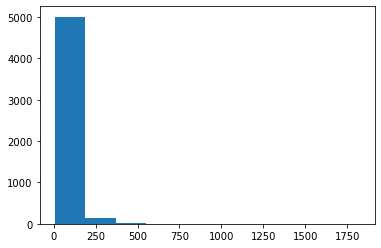

In [10]:
plt.hist(validate_biomasses)
plt.show()

In [7]:
pd.Series(train_biomasses).describe()

count    2.503600e+04
mean              inf
std               inf
min      4.511719e+00
25%      1.642188e+01
50%      2.554688e+01
75%      5.196875e+01
max      8.630000e+02
dtype: float64

In [8]:
y_binary=(pd.concat([pd.Series(train_biomasses)])>150).astype(int)
y_binary.value_counts()

0    23756
1     1280
dtype: int64

In [66]:
X=pd.concat([train, val, val2])
y_binary=(pd.concat([pd.Series(train_biomasses), pd.Series(validate_biomasses), pd.Series(test_biomasses)])>150).astype(int)
y=pd.concat([pd.Series(train_biomasses), pd.Series(validate_biomasses), pd.Series(test_biomasses)])

In [67]:
X['target']=y
corr=X.corr()['target'].sort_values(ascending=False)
corr=corr[(corr>0.01) | (corr<-0.01)]
corr

In [42]:
X=X[corr.index].drop('target', axis=1)
testdf=testdf[X.columns]

## Modelisation

In [57]:
X=pd.concat([train, val, val2])
y_binary=(pd.concat([pd.Series(train_biomasses), pd.Series(validate_biomasses), pd.Series(test_biomasses)])>150).astype(int)
y=pd.concat([pd.Series(train_biomasses), pd.Series(validate_biomasses), pd.Series(test_biomasses)])

#### checking test and train pair wise relations

In [75]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold


X=pd.concat([train, val, val2])
y_binary=(pd.concat([pd.Series(train_biomasses), pd.Series(validate_biomasses), pd.Series(test_biomasses)])>150).astype(int)

model=CatBoostClassifier(learning_rate=0.01051006124,
    random_state=0,
    n_estimators=3000,
    auto_class_weights='Balanced'
)
skfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=5234)
oof = np.zeros(len(X))
predictions = []
for fold, (trn_idx, val_idx) in enumerate(skfold.split(X, y_binary)):
    print(f'Fold {fold + 1}')
    X_train, y_train = X.iloc[trn_idx], y_binary.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y_binary.iloc[val_idx]
    
    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        verbose=300,
        early_stopping_rounds=300,
        use_best_model=True
    )
    y_hat=model.predict_proba(X_valid)[:, 1]
    oof[val_idx] = y_hat
    predictions.append(model.predict_proba(testdf)[:1])
    print(f1_score(y_valid, (y_hat>0.5).astype(int)))

predictions = np.mean(predictions, axis=1)
print(f'Our oof mse score is {f1_score(y_binary, (oof>0.5).astype(int))}')

Fold 1
0:	learn: 0.6925097	test: 0.6928678	best: 0.6928678 (0)	total: 127ms	remaining: 6m 19s
300:	learn: 0.6002968	test: 0.6736619	best: 0.6735687 (298)	total: 12.9s	remaining: 1m 56s
600:	learn: 0.5441802	test: 0.6755624	best: 0.6729767 (391)	total: 26.9s	remaining: 1m 47s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.67297668
bestIteration = 391

Shrink model to first 392 iterations.


CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 0 should be feature with name 0 (found mean_pixel).

In [ ]:
X['target']=oof
X=X[y_feat==0]

In [ ]:
X=X[X['target']>0.2]
y=y.iloc[X.index]

y_binary=y_binary.iloc[X.index]
X=X.drop('target', axis=1)

#### predicting probability of being outlier or not

In [81]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

X=pd.concat([train, val, val2])
X['label']=0
x2=testdf.copy()
x2['label']=1
df=pd.concat([X, x2])
X=df.drop('label', axis=1)
y_feat=df['label']

model=CatBoostClassifier(learning_rate=0.01051006124,
    random_state=0,
    n_estimators=3000,
    auto_class_weights='Balanced'
)
skfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=5234)
oof = np.zeros(len(X))
predictions = []
for fold, (trn_idx, val_idx) in enumerate(skfold.split(X, y_feat)):
    print(f'Fold {fold + 1}')
    X_train, y_train = X.iloc[trn_idx], y_feat.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y_feat.iloc[val_idx]
    
    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        verbose=300,
        early_stopping_rounds=300,
        use_best_model=True
    )
    y_hat=model.predict_proba(X_valid)[:, 1]
    oof[val_idx] = y_hat
    print(f1_score(y_valid, (y_hat>0.5).astype(int)))

print(f'Our oof mse score is {f1_score(y_feat, (oof>0.5).astype(int))}')

Fold 1
0:	learn: 0.6885390	test: 0.6907929	best: 0.6907929 (0)	total: 197ms	remaining: 9m 50s
300:	learn: 0.1821531	test: 0.7242271	best: 0.6037625 (99)	total: 15.9s	remaining: 2m 22s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.603762468
bestIteration = 99

Shrink model to first 100 iterations.
0.02588996763754045
Fold 2
0:	learn: 0.6877666	test: 0.6908619	best: 0.6908619 (0)	total: 179ms	remaining: 8m 56s
300:	learn: 0.1826384	test: 0.7904585	best: 0.6193726 (63)	total: 17.2s	remaining: 2m 34s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.6193725996
bestIteration = 63

Shrink model to first 64 iterations.
0.03453237410071943
Fold 3
0:	learn: 0.6866004	test: 0.6905262	best: 0.6905262 (0)	total: 167ms	remaining: 8m 21s
300:	learn: 0.1707376	test: 0.8930270	best: 0.6449297 (64)	total: 16.4s	remaining: 2m 27s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.6449297226
bestIteration = 64

Shrink model to first 65 iteration

In [58]:
thershold=abs(y_binary-oof)
label=pd.DataFrame({'error':thershold, 'target':y})
label=label[(label['error']<0.85) & (label['target']>250) | (label['error']<0.7) & (label['target']<60)] 

y=y.iloc[label.index]
X=X.iloc[label.index]
y_binary=y_binary.iloc[label.index]

In [60]:
oof_1=pd.Series(oof)
X['oof1']=oof_1.iloc[X.index]
testdf['oof1']=model.predict_proba(testdf)[:, 1]

#### train main model

In [50]:
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
#=pd.concat([train, val, val2])
#y_binary=(pd.concat([pd.Series(train_biomasses), pd.Series(validate_biomasses), pd.Series(test_biomasses)])>150).astype(int)
#y=pd.concat([pd.Series(train_biomasses), pd.Series(validate_biomasses), pd.Series(test_biomasses)])
model=CatBoostRegressor(learning_rate=0.1051006124,
    random_state=0,
    n_estimators=3000,
)
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=5234)
oof = np.zeros(len(X))
predictions = []
for fold, (trn_idx, val_idx) in enumerate(skfold.split(X, y_binary)):
    print(f'Fold {fold + 1}')
    X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
    
    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        verbose=300,
        early_stopping_rounds=300,
    )
    y_hat=model.predict(X_valid)
    oof[val_idx] = y_hat
    predictions.append(model.predict(testdf))
    print(mean_squared_error(y_valid, y_hat))

predictions = np.mean(predictions, axis=0)
print(f'Our oof mse score is {mean_squared_error(y, oof)}')
#print(f'Our oof mse score is {mean_squared_error(test_biomasses, model.predict)}')


Fold 1
0:	learn: 58.8513728	test: 56.5915437	best: 56.5915437 (0)	total: 81.6ms	remaining: 4m 4s
300:	learn: 50.7331991	test: 53.9849848	best: 53.9683075 (288)	total: 12.1s	remaining: 1m 48s
600:	learn: 46.8547763	test: 53.9467350	best: 53.9097920 (494)	total: 24s	remaining: 1m 35s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 53.90979203
bestIteration = 494

Shrink model to first 495 iterations.
2906.2656770305875
Fold 2
0:	learn: 57.7248157	test: 66.3621294	best: 66.3621294 (0)	total: 90.6ms	remaining: 4m 31s
300:	learn: 49.8884867	test: 63.7406610	best: 63.7359888 (297)	total: 12.6s	remaining: 1m 53s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 63.73598884
bestIteration = 297

Shrink model to first 298 iterations.
4062.2762730194195
Fold 3
0:	learn: 58.7091335	test: 57.7441341	best: 57.7441341 (0)	total: 162ms	remaining: 8m 6s
300:	learn: 50.5336024	test: 54.2314636	best: 54.1922905 (291)	total: 13.3s	remaining: 1m 58s
600:	learn: 46.605529

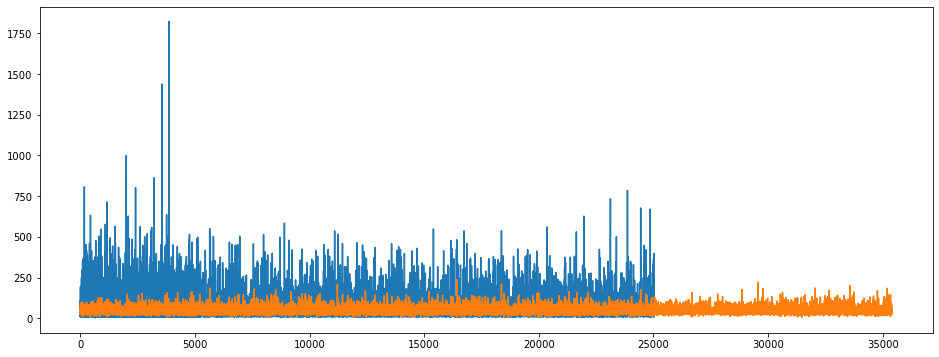

In [51]:
import seaborn as sns
plt.figure(figsize=(16, 6))
plt.plot(y)
plt.plot(oof)
#plt.legend(['treue', 'predict'])
#plt.plot(y-oof)

In [52]:
history=pd.DataFrame({'target':y, 'predict':oof})
history['error']=abs(history['target']-history['predict'])
history[history['error']>50].sort_values(by=['target'], ascending=False)[:30]

,target,predict,error
3869,1822.330566,60.297841,1762.032725
3561,1438.000000,28.951481,1409.048519
2006,1000.065796,36.971508,963.094288
3219,863.000000,60.532611,802.467389
177,807.000000,85.802866,721.197134
2410,802.500000,41.979936,760.520064
23864,785.500000,95.921251,689.578749
23121,733.500000,51.538917,681.961083
2000,725.000000,83.372231,641.627769
1164,714.609863,60.634615,653.975249


#### train the model on more filterd data

In [51]:
seed=0
model = LGBMRegressor(
    n_estimators=90,
    learning_rate=0.303006124,
    random_state=0,
)

predictions = []
#X=X[feat.index]
#test=test[feat.index]
#valid=valid[feat.index]
model.fit(val, validate_biomasses,
        eval_set=(val, validate_biomasses),
        verbose=50,
        early_stopping_rounds=50,
    )
y_hat=model.predict(val)
predictions.append((model.predict(testdf)))
print(mean_squared_error((validate_biomasses), y_hat))
predictions = np.mean(predictions, axis=0)
#print(f'Our oof mse score is {mean_squared_error(, oof)}')

[50]	training's l2: 781.092
311.36327781803436


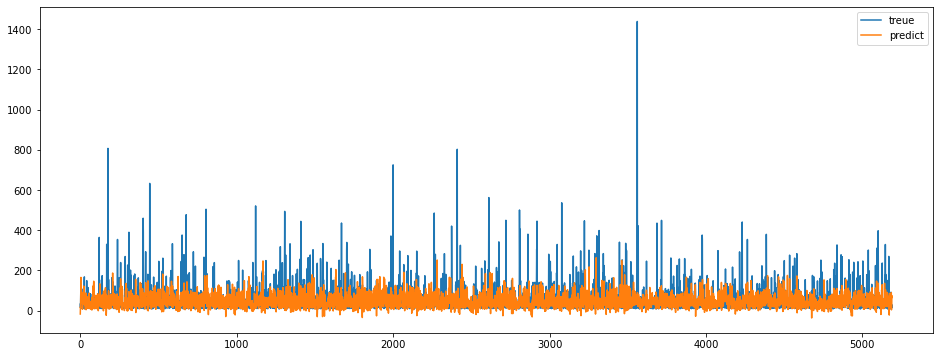

In [52]:
import seaborn as sns
plt.figure(figsize=(16, 6))
plt.plot(test_biomasses, )
plt.plot(model.predict(val2))
plt.legend(['treue', 'predict'])
#plt.plot(y-oof)

In [29]:
seed=0
model = LGBMRegressor(
    n_estimators=40000,
    learning_rate=0.001006124,
    random_state=0,
)

predictions = []
#X=X[feat.index]
#test=test[feat.index]
#valid=valid[feat.index]
model.fit(train, train_biomasses,
        eval_set=(val, validate_biomasses),
        verbose=500,
        early_stopping_rounds=500,
    )
y_hat=model.predict(val2)
predictions.append((model.predict(testdf)))
print(mean_squared_error((test_biomasses), y_hat))
predictions = np.mean(predictions, axis=0)
#print(f'Our oof mse score is {mean_squared_error(, oof)}')

[500]	valid_0's l2: 3975.01
[1000]	valid_0's l2: 3924.79
[1500]	valid_0's l2: 3896.06
[2000]	valid_0's l2: 3881.07
[2500]	valid_0's l2: 3870.94
[3000]	valid_0's l2: 3863.31
[3500]	valid_0's l2: 3854.04
[4000]	valid_0's l2: 3848.14
[4500]	valid_0's l2: 3842.96
[5000]	valid_0's l2: 3838.32
[5500]	valid_0's l2: 3837.34
3867.331428752697


In [17]:
history=pd.DataFrame({'target':y, 'predict':oof})
history['error']=abs(history['target']-history['predict'])
history[history['error']>50].sort_values(by=['target'], ascending=False)[:30]

,target,predict,error
3219,863.00,43.741320,819.258680
23864,785.50,85.653621,699.846379
23121,733.50,38.965897,694.534103
24442,677.50,121.911345,555.588655
21963,627.50,37.558283,589.941717
8903,584.50,51.672108,532.827892
1091,577.00,59.692127,517.307873
1091,577.00,59.692127,517.307873
20356,560.50,21.270834,539.229166
5644,550.50,99.683267,450.816733


In [53]:
ID_S2_pair = pd.read_csv('UniqueID-SentinelPair.csv')

preds = pd.DataFrame({'Target':predictions}).rename_axis('S2_idx').reset_index()
preds = ID_S2_pair.merge(preds, on='S2_idx').drop(columns=['S2_idx'])
preds.to_csv('GIZ_Biomass_predictions_by_lgb.csv', index=False)
display(preds)
preds.describe()


,ID,Target
0,ID_1EB0DGFP07,39.814578
1,ID_844T2PSXTK,46.595259
2,ID_4MCV3S8MLN,33.319847
3,ID_L7441JV5F3,38.954178
4,ID_5GUVM4YEWZ,45.543331
...,...,...
85,ID_MEW6189J1B,71.467047
86,ID_TH9HRUXGTP,50.669940
87,ID_GPC7YS3JG8,49.631411
88,ID_1P7PJMPV0R,61.116456


,Target
count,90.000000
mean,50.612440
std,11.888301
min,23.514217
25%,42.845670
50%,48.105065
75%,57.599199
max,82.014628


array([[<AxesSubplot:title={'center':'Target'}>]], dtype=object)

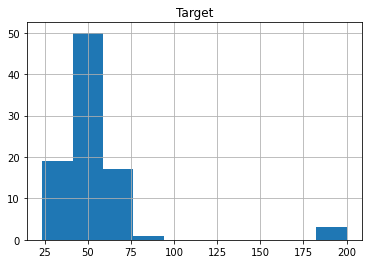

In [58]:
preds.hist()